# Preprocessing
## Imports

In [95]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as transforms
import tarfile
import pandas as pd
from PIL import Image

### Opening Data Files

In [5]:
def open_tar(filename, dest=None):
    with tarfile.open(filename, 'r:gz') as tar:
        if dest is None:
            tar.extractall('./')
        else:
            tar.extractall(dest)
    print("Extraction successful!")

Below extracts into pokemon/icons path

In [15]:
open_tar("./datasource/pokemon-icons.tar.gz")

Extraction successful!


Below extracts into pokemon/main-sprites path

In [16]:
open_tar("./datasource/generation-1.tar.gz")

Extraction successful!


### Create Pokedex
Pokedex for our purpose is simply a pandas dataframe that maps a pokemon's index to its name. Many images are simply called "1.png" so this data structure allows us to determine that "1.png" is bulbasaur

In [20]:
def make_pokedex(path="pokedex/pokemon.csv"):
    pokedex = pd.read_csv(path)
    return pokedex

In [21]:
pokedex = make_pokedex()
print(pokedex)

            Name     Type1   Type2
0      bulbasaur     Grass  Poison
1        ivysaur     Grass  Poison
2       venusaur     Grass  Poison
3     charmander      Fire     NaN
4     charmeleon      Fire     NaN
..           ...       ...     ...
804    stakataka      Rock   Steel
805  blacephalon      Fire   Ghost
806      zeraora  Electric     NaN
807       meltan     Steel     NaN
808     melmetal     Steel     NaN

[809 rows x 3 columns]


Here I determine the name of the pokemon located at index 49

In [186]:
pokedex["Name"][49]

'diglett'

## Image Augmentation

In [73]:
# Sample image to test augmentations on
img = Image.open("pokedex/images/images/abra.png")
img.show()

### Rotation

In [174]:
# Rotates an image by a random amount. Set the "rot" parameter if you want to rotate by a specific degree amount
def img_rotate(img, rot=None):
    if rot is None:
        rot = np.random.uniform(0, 360)
    
    rot_img = img.rotate(rot)
#     rot_img.show(title="Rotated Image")
    return rot_img

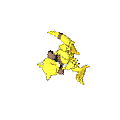

In [173]:
# Test random rotation
img_rotate(img)

### Todo: (Add noise, zoom in, etc?)

## Organize Samples

### Locations with images that are useful:
* pokemon/main-sprites (png for all pixelated gen1 pokemon!)
    * ./red-blue (red/blue version of sprites)
    * ./red-green (red/green version of sprites)
    * ./yellow (yellow version of sprites)
    
* pokedex/images/images (high def images)

* pokemon/icons (pixelated images and root of below subfolders. Not all pokemon have them!)
    * pokemon/icons/old (pixelated old images. Not all pokemon have them!)
    * pokemon/icons/right (pixelated images flipped. Not all pokemon have them!)

**Currently I only load all subfolders of pokemon/main-sprites because the images are pixelated and there is one for each pokemon**

In [175]:
# Saves an image at the "dest" path with a unique name tracked by the "counter" dict.
# img: The image to be saved
# name: The name of the pokemon
# ind: The index of the pokemon
# dest: The destination. Which subfolder will the image be saved in
# counter: A dictionary that keeps track of how many images are in each of the pokemon subfolders
    # The image's file name is determined by this count, found by indexing the dict with pokemon's "ind"
    # After each save, this function increment's the pokemon's counter by 1

def smart_save(img, name, ind, dest, counter):
    fname = name + str(counter[ind]) + ".png"
    img.save(dest + fname)
    counter[ind] += 1

In [184]:
# Organizes and augments samples to be used for training
# start_ind/end_ind: The index range of the pokemon to be used for classification
# pokedex: See above section "Create Pokedex". A pandas dataframe associating pokemon ind to name
# augment: A dictionary where augment parameters are defined. Empty dict means only use source images w/out augment
    # If the key "rotate" is present, include x rotated versions of the source images where x in the value
        #associated with the key
        
def sample_data(start_ind, end_ind, pokedex, augment={}):
    # Define the sources where images will be drawn from
    sources = []
    rb_sprites = "./pokemon/main-sprites/red-blue/"
    sources.append(rb_sprites)
    rg_sprites = "./pokemon/main-sprites/red-green/"
    sources.append(rg_sprites)
    y_sprites = "./pokemon/main-sprites/yellow/"
    sources.append(y_sprites)
    
    # The file_counter keeps track of how many images are currently saved for each pokemon
    # The keys in this case are the pokemon's index
    file_counter = dict(enumerate([0] * (end_ind - start_ind)))
    for ind in range(start_ind, end_ind):
        # Use pokedex to get the pokemon's name and create the subfolder for its images
        name = pokedex["Name"][ind]
        class_directory = './samples/' + name + "/"
        if not os.path.exists(class_directory):
            os.makedirs(class_directory)
        
        # indices start at 0 but pokemon id's start at 1. Define the source image using pokemon id
        id_ = ind + 1
        source_img = str(id_) + ".png"
        # For each source defined, open and save the image. Apply augmentations and save modified imgs if applicable
        for source in sources:   
            try:
                img = Image.open(source + source_img)
                smart_save(img, name, ind, class_directory, file_counter)
                
                # Augmentations begin here
                rotations = 0 if "rotate" not in augment else augment["rotate"]
                for _ in range(rotations):
                    rot_img = img_rotate(img)
                    smart_save(rot_img, name, ind, class_directory, file_counter)
            except FileNotFoundError as e:
                print("File not found:", e.filename)
                pass
            
            img.close()

In [185]:
# Store samples for the first 50 pokemon and for each source, include 2 rotated versions of the image
sample_data(0, 50, pokedex, {"rotate": 2})